# Cost landscapes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from openqaoa.algorithms import QAOA
from openqaoa.problems import MaximumCut
from openqaoa.backends import create_device
import os
import json
import networkx as nx
import pickle
import itertools

from qiskit_aer.noise import (NoiseModel, depolarizing_error)
from qiskit import transpile


### Define helper functions

In [2]:
# helper function to produce the cost landscape
def plot_cost_landscape(mixer_angle_iter, cost_angle_iter, variational_params, backend,
                       previous_mixer_angles:list,
                       previous_cost_angles:list):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.

    Parameters
    ----------

    """
    cost_landscape = np.zeros((mixer_angle_iter.size,mixer_angle_iter.size),dtype=float)

    for i,mixer_angle in enumerate(mixer_angle_iter):
        for j,cost_angle in enumerate(cost_angle_iter):
            new_variational_params = []
            new_variational_params.extend(previous_mixer_angles)
            new_variational_params.extend([mixer_angle])
            new_variational_params.extend(previous_cost_angles)
            new_variational_params.extend([cost_angle])
            variational_params.update_from_raw(new_variational_params)
            cost_landscape[i,j] = backend.expectation(variational_params)

    return cost_landscape

In [3]:
def read_files(problems_directories,problem_best_files,bechmarktype_director):    
    # iterate over the problem directories
    results = []
    for problem_index,(problem_dir,problem_bf) in enumerate(zip(problems_directories,problem_best_files)):
        
        # form the complete directory for the current problem
        file_path = 'results_cvar_qaoa/'+problem_dir+'/'+bechmarktype_director+"/"+'prob'+problem_bf+'.json'
    
        # initialize problem substructure

        # create the complete filepath and the shortened filename (that is, just showing QAOA hyperparameters + cvar)
        #file_path = os.path.join(complete_dir, problem_bf+'.json')
        shortened_filename = problem_bf[4:-5]
    
        # open the file
        with open(file_path, 'r', encoding='utf-8') as file:
            try:
                # load the file as a dict and get its relevant information
                jsondata = json.load(file) 
                angles = jsondata['optimized']['angles']
                itrm_angles = jsondata['intermediate']['angles']

                # update the cost, cost fev number and nfev sumatories, and the min-max values if neccesary
                results.append({})
                results[problem_index]['angles'] = angles
                results[problem_index]['itrm_angles'] = itrm_angles
                
                del jsondata
            except json.JSONDecodeError as e:
                print(f"Error uploading {file_path}: {e}")
    
    return results

### Read files

In [4]:
problems_directories = ['prob0','prob1','prob2','prob3','prob4'] # directorioes for each problem

problems_directories = ['prob0','prob1','prob2','prob3','prob4'] # directorioes for each problem

best_cvar_configuration_names = [
    '0.5_p5-standard-ramp-x-COBYLA',
    '0.5_p4-standard-ramp-x-COBYLA',
    '0.4_p5-standard-ramp-x-COBYLA',
    '0.2_p5-standard-ramp-x-COBYLA',
    '0.3_p5-standard-ramp-x-COBYLA'
]

best_exp_configuration_names = [
    '1.0_p5-standard-ramp-x-COBYLA',
    '1.0_p4-standard-ramp-x-COBYLA',
    '1.0_p4-standard-ramp-x-COBYLA',
    '1.0_p5-standard-ramp-x-COBYLA',
    '1.0_p5-standard-ramp-x-COBYLA'
]

In [5]:
noiselesscvar_confs = [a+'_noiseless' for a in best_cvar_configuration_names]

problems_noiselesscvar = read_files(problems_directories,noiselesscvar_confs,'noiselessCVAR' )
#problems_noiselesscvar

In [6]:
noisycvar_confs = [a+'_noisycvar' for a in best_cvar_configuration_names]

problems_noisycvar = read_files(problems_directories,noisycvar_confs,'noisyCVAR' )
#problems_noisycvar

In [7]:
noiselessexp_confs = [a+'_noiseless' for a in best_exp_configuration_names]

problems_noiselessexp = read_files(problems_directories,noiselessexp_confs,'noiselessEXP')
#problems_noiselessexp

In [8]:
noisyexp_confs = [a+'_noisyexp' for a in best_exp_configuration_names]

problems_noisyexp = read_files(problems_directories,noisyexp_confs,'noisyEXP')
#problems_noisyexp

### Define noise model

In [9]:
one_qubit_gates = ['h','rx']
two_qubits_gates = ['cx']

#create depol. noise
def add_depolarizing_error(noise_model,prob1, prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

noise_model = add_depolarizing_error(NoiseModel(),0.0002379, 0.00507) #ibm_fez, 07/03/2025 (dd/mm/yyyy)

### Define MaxCut problems

In [10]:
graph1 = nx.Graph()
graph1.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph1.add_edges_from([(0, 6), (0, 8), (1, 5), (2, 7), (2, 8), (3, 5), (3, 7), (4, 8), (6, 7), (7, 9), (8, 9)])

graph2 = nx.Graph()
graph2.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph2.add_edges_from([(0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 8), (1, 4), (1, 6), (1, 8), (1, 9), (2, 4), (2, 6), (3, 4), (3, 6), (3, 8), (3, 9), (4, 5), (4, 7), (4, 9), (5, 8), (6, 7), (7, 8), (7, 9), (8, 9)])

graph3 = nx.Graph()
graph3.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph3.add_edges_from([(0, 1), (0, 2), (0, 4), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 7), (4, 8), (5, 6), (5, 7), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9)])

graph4 = nx.Graph()
graph4.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph4.add_edges_from([(0, 3), (1, 3), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (3, 4), (3, 6), (3, 7), (4, 5), (4, 6), (4, 9), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9)])

graph5 = nx.Graph()
graph5.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
graph5.add_edges_from([(0, 5), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 6), (1, 9), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (3, 5), (3, 6), (3, 7), (3, 9), (4, 6), (4, 7), (4, 9), (5, 6), (6, 7), (6, 8), (7, 9)])

mc1 = MaximumCut(graph1)
mc2 = MaximumCut(graph2)
mc3 = MaximumCut(graph3)
mc4 = MaximumCut(graph4)
mc5 = MaximumCut(graph5)

### Create data structures to iterate

In [11]:
mcs = [mc1, mc2, mc3, mc4, mc5]

In [73]:
ps_exp = [4,4,4,4,4]

#angles_sets =  [problemdatas[i]['angles'] for i in range(5)]
betas_sets_noiselessexp = [problems_noiselessexp[i]['angles'][len(problems_noiselessexp[i]['angles'])//2:] for i in range(5)]
gammas_sets_noiselessexp = [problems_noiselessexp[i]['angles'][:len(problems_noiselessexp[i]['angles'])//2]  for i in range(5)]

itrm_betas_sets_noiselessexp = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of betas
itrm_gammas_sets_noiselessexp = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of gammas
for i,j in itertools.product(range(5),range(4)):
    l = len( problems_noiselessexp[i]['itrm_angles'])
    params = problems_noiselessexp[i]['itrm_angles'][(j+1)*l//5]
    l = len(params)
    #params = [params[l//4],params[2*l//4],params[3*l//4]]
    itrm_betas_sets_noiselessexp[i,j] = params[l//2:]
    itrm_gammas_sets_noiselessexp[i,j] = params[:l//2]

In [75]:
betas_sets_noisyexp = [problems_noisyexp[i]['angles'][len(problems_noisyexp[i]['angles'])//2:] for i in range(5)]
gammas_sets_noisyexp = [problems_noisyexp[i]['angles'][:len(problems_noisyexp[i]['angles'])//2]  for i in range(5)]

itrm_betas_sets_noisyexp = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of betas
itrm_gammas_sets_noisyexp = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of gammas
for i,j in itertools.product(range(5),range(4)):
    l = len( problems_noisyexp[i]['itrm_angles'])
    params = problems_noisyexp[i]['itrm_angles'][(j+1)*l//5]
    l = len(params)
    #params = [params[l//4],params[2*l//4],params[3*l//4]]
    itrm_betas_sets_noisyexp[i,j] = params[l//2:]
    itrm_gammas_sets_noisyexp[i,j] = params[:l//2]

In [76]:
ps_cvar = [4,4,4,4,4]

#angles_sets =  [problems_noiselesscvar[i]['angles'] for i in range(5)]
betas_sets_noiselesscvar = [problems_noiselesscvar[i]['angles'][len(problems_noiselesscvar[i]['angles'])//2:] for i in range(5)]
gammas_sets_noiselesscvar = [problems_noiselesscvar[i]['angles'][:len(problems_noiselesscvar[i]['angles'])//2]  for i in range(5)]

itrm_betas_sets_noiselesscvar = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of betas
itrm_gammas_sets_noiselesscvar = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of gammas
for i,j in itertools.product(range(5),range(4)):
    l = len( problems_noiselesscvar[i]['itrm_angles'])
    params = problems_noiselesscvar[i]['itrm_angles'][(j+1)*l//5]
    l = len(params)
    #params = [params[l//4],params[2*l//4],params[3*l//4]]
    itrm_betas_sets_noiselesscvar[i,j] = params[l//2:]
    itrm_gammas_sets_noiselesscvar[i,j] = params[:l//2]

In [77]:
betas_sets_noisycvar = [problems_noisycvar[i]['angles'][len(problems_noisycvar[i]['angles'])//2:] for i in range(5)]
gammas_sets_noisycvar = [problems_noisycvar[i]['angles'][:len(problems_noisycvar[i]['angles'])//2]  for i in range(5)]

itrm_betas_sets_noisycvar = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of betas
itrm_gammas_sets_noisycvar = np.empty((5,4),dtype=object) # f(problem,itrm_itr) = array of gammas
for i,j in itertools.product(range(5),range(4)):
    l = len( problems_noisycvar[i]['itrm_angles'])
    params = problems_noisycvar[i]['itrm_angles'][(j+1)*l//5]
    l = len(params)
    #params = [params[l//4],params[2*l//4],params[3*l//4]]
    itrm_betas_sets_noisycvar[i,j] = params[l//2:]
    itrm_gammas_sets_noisycvar[i,j] = params[:l//2]

In [81]:
# set of data for the general colour map
# from now on, run cells twice either with 'NOISELESS' and with 'NOISY'
environment_type = 'noisy'

if environment_type == 'noiseless':
    problemdatas=problems_noiselesscvar
    ps = ps_cvar
    betas_sets = betas_sets_noiselesscvar
    gammas_sets = gammas_sets_noiselesscvar

    gammas_sets_cvar = gammas_sets_noiselesscvar
    betas_sets_cvar = betas_sets_noiselesscvar
    gammas_sets_exp= gammas_sets_noiselessexp
    betas_sets_exp= betas_sets_noiselessexp

    itrm_gammas_sets_cvar = itrm_gammas_sets_noiselesscvar
    itrm_betas_sets_cvar = itrm_betas_sets_noiselesscvar
    itrm_gammas_sets_exp= itrm_gammas_sets_noiselessexp
    itrm_betas_sets_exp= itrm_betas_sets_noiselessexp
elif environment_type == 'noisy':
    problemdatas=problems_noisycvar
    ps = ps_cvar
    betas_sets = betas_sets_noisycvar
    gammas_sets = gammas_sets_noisycvar

    gammas_sets_cvar = gammas_sets_noisycvar
    betas_sets_cvar = betas_sets_noisycvar
    gammas_sets_exp= gammas_sets_noisyexp
    betas_sets_exp= betas_sets_noisyexp

    itrm_gammas_sets_cvar = gammas_sets_noisycvar
    itrm_betas_sets_cvar = betas_sets_noisycvar
    itrm_gammas_sets_exp= gammas_sets_noisyexp
    itrm_betas_sets_exp= betas_sets_noisyexp

### Create QAOAs

In [82]:
qaoas = []
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')

for i,(betas,gammas,p,mc) in enumerate(zip(betas_sets,gammas_sets,ps,mcs)):
    qaoas.append([])
    for p_to_evaluate in range(1,p+1):
        params = {"betas":betas[:p_to_evaluate], "gammas":gammas[:p_to_evaluate]}
        qaoa = QAOA()
        qaoa.set_circuit_properties(p=p_to_evaluate, init_type="custom", variational_params_dict=params)

        if environment_type == 'noiseless':
                qaoa.set_backend_properties(n_shots=5000,seed_simulator=1)
        elif environment_type =='noisy':
                qaoa.set_backend_properties(n_shots=5000,seed_simulator=1,noise_model=noise_model)

        qaoa.set_classical_optimizer(maxiter=0)
        qaoa.set_device(qiskit_device)
        qaoa.compile(mc.qubo)

        if environment_type == 'noisy':
            qaoa.backend.parametric_circuit = transpile(qaoa.backend.parametric_circuit,basis_gates=["h","rx","cx"])
        
        qaoa.optimize()
        qaoas[i].append(qaoa)

### Calculate clost landscapes

In [91]:

# cost landscape for standard parameterization
gammas_space = np.linspace(-np.pi,np.pi,25) # pass to 100 for final plot
betas_space = np.linspace(-np.pi/2,np.pi/2,25) # pass to 100 for final plot

RUN = False
if RUN:
    cost_landscapes = []
 
    for i,qaoas_of_problem in enumerate(qaoas):
        cost_landscapes.append([])
        for max_p,qaoa in enumerate(qaoas_of_problem):
            #if max_p != 3:
            #    continue
            print('on problem',str(i),', max_p = ',max_p,end='\r')
            
            previous_mixer_angles = qaoa.variate_params.betas[:max_p]  if max_p > 0 else []
            previous_cost_angles = qaoa.variate_params.gammas[:max_p] if max_p > 0 else []
    
            cost_landscape = plot_cost_landscape(np.array(betas_space), np.array(gammas_space), qaoa.variate_params, qaoa.backend,
                                                previous_mixer_angles,previous_cost_angles)
            cost_landscapes[i].append(cost_landscape)

        with open(environment_type+'_cost_landscapes.pkl', 'wb') as f:
            pickle.dump(cost_landscapes, f)
        
    with open(environment_type+'_cost_landscapes.pkl', 'rb') as f:
        cost_landscapes = pickle.load(f)
    with open(environment_type+'_cost_landscapes.pkl', 'rb') as f:
        squared_cost_landscapes = pickle.load(f) # each problem will have information just for p=1,2,3
else:
    with open(environment_type+'_cost_landscapes.pkl', 'rb') as f:
        cost_landscapes = pickle.load(f)
    with open(environment_type+'_cost_landscapes.pkl', 'rb') as f:
        squared_cost_landscapes = pickle.load(f) # each problem will have information just for p=1,2,3

In [92]:
# the squared cost landscape is postprocessed to make it a tensor
max_p = 4
for i,cl in enumerate(squared_cost_landscapes):
    squared_cost_landscapes[i] = cl
squared_cost_landscapes = np.array(squared_cost_landscapes) 
print('new shape:',squared_cost_landscapes.shape)

new shape: (5, 4, 25, 25)


In [93]:
averaged_cost_landscapes = np.mean(squared_cost_landscapes,axis=(0))
print('new shape:', averaged_cost_landscapes.shape)

new shape: (4, 25, 25)


### Plot per problem

PROBLEM 0 FOR LAYER 0


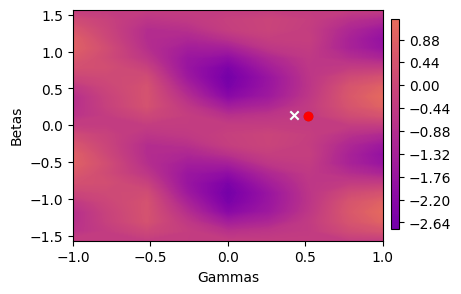

PROBLEM 1 FOR LAYER 0


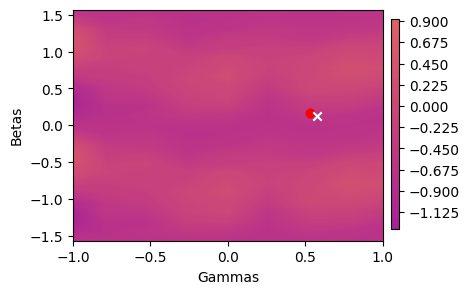

PROBLEM 2 FOR LAYER 0


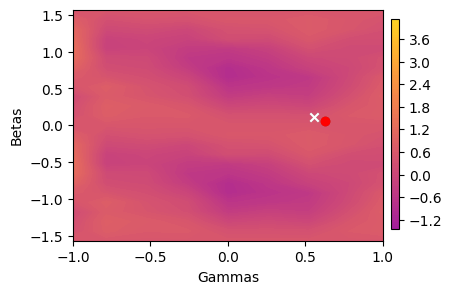

PROBLEM 3 FOR LAYER 0


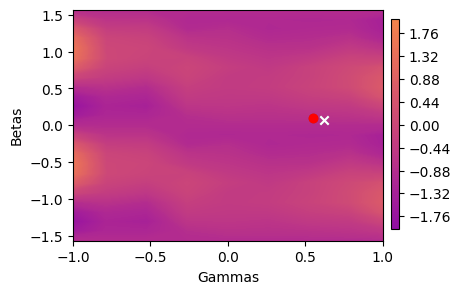

PROBLEM 4 FOR LAYER 0


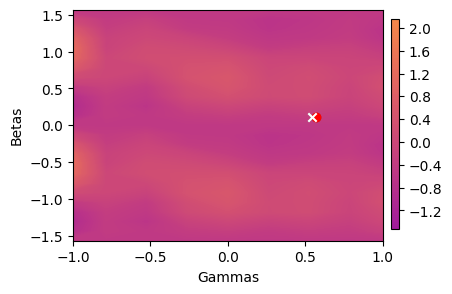

PROBLEM 0 FOR LAYER 1


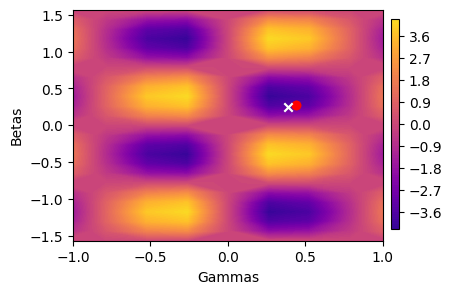

PROBLEM 1 FOR LAYER 1


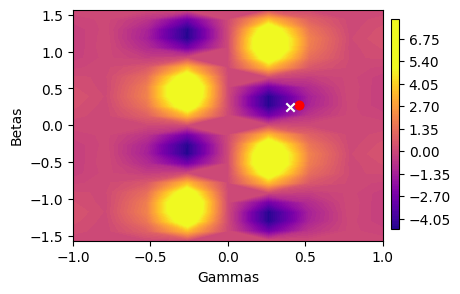

PROBLEM 2 FOR LAYER 1


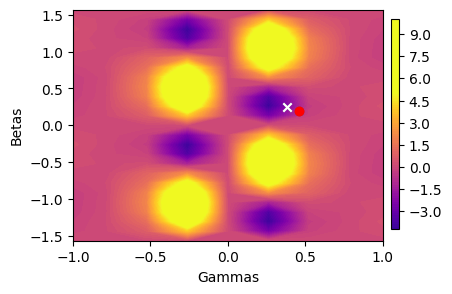

PROBLEM 3 FOR LAYER 1


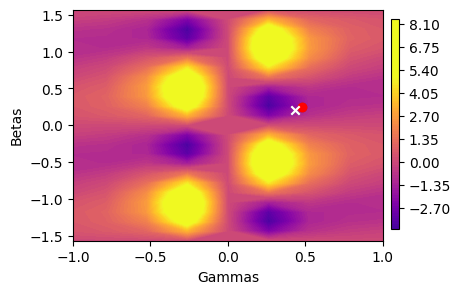

PROBLEM 4 FOR LAYER 1


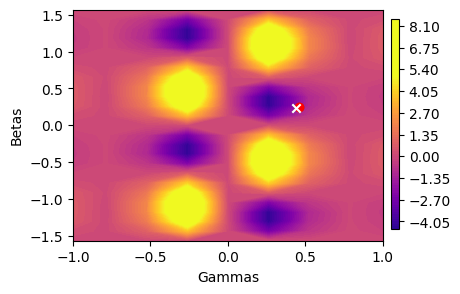

PROBLEM 0 FOR LAYER 2


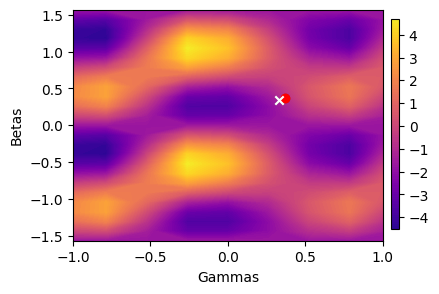

PROBLEM 1 FOR LAYER 2


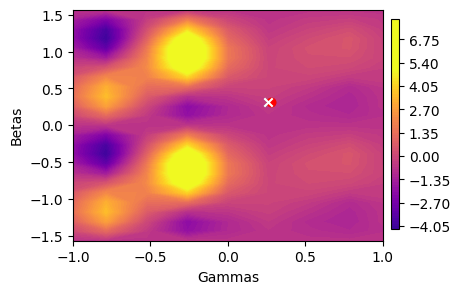

PROBLEM 2 FOR LAYER 2


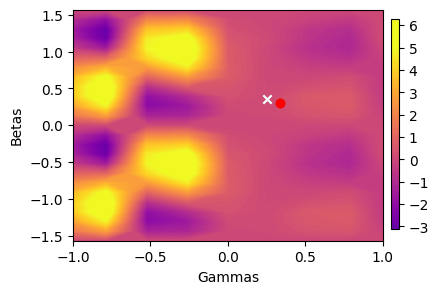

PROBLEM 3 FOR LAYER 2


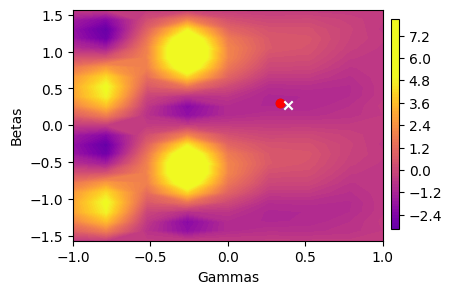

PROBLEM 4 FOR LAYER 2


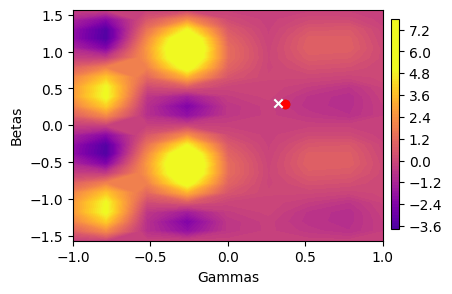

PROBLEM 0 FOR LAYER 3


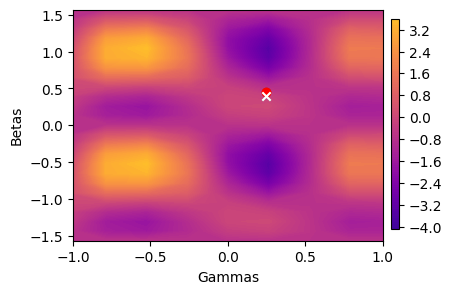

PROBLEM 1 FOR LAYER 3


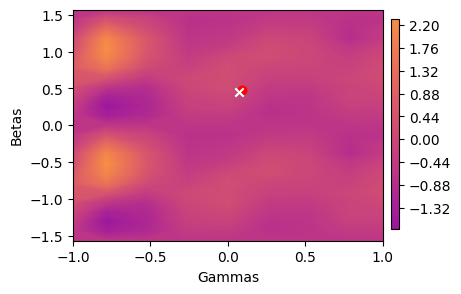

PROBLEM 2 FOR LAYER 3


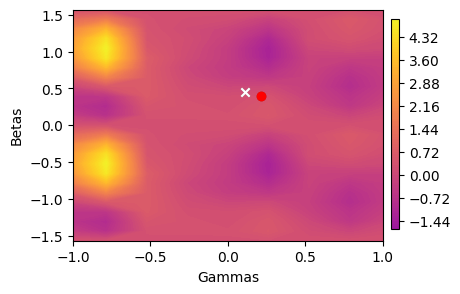

PROBLEM 3 FOR LAYER 3


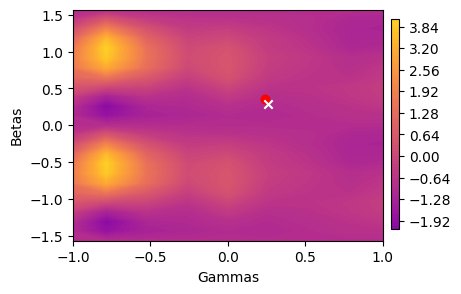

PROBLEM 4 FOR LAYER 3


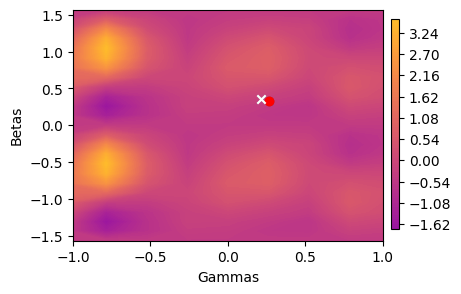

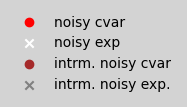

In [94]:
for p_to_evaluate in range(4):
    for i,cost_landscape in enumerate(cost_landscapes):
        try:
            print('PROBLEM',i,'FOR LAYER',p_to_evaluate)
            fig, ax = plt.subplots(figsize=(4, 3))
            cmap = 'plasma' # it previously was viridis
            im = ax.contourf(cost_landscape[p_to_evaluate-1], cmap=cmap, levels=100, 
                             extent=(gammas_space[0], gammas_space[-1], betas_space[0], betas_space[-1])
                            ,vmin=-5,vmax=5)

            #ax.set_title('Cost Landscape for Standard Parameterization')
            ax.set_xlabel('Gammas')
            ax.set_ylabel('Betas')
        
            # Ajuste de la barra de color
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
            cbar=fig.colorbar(im, cax=cbar_ax)

            # Add fixed points as scatter points 
            fixed_gammas = [gammas_sets_cvar[i][p_to_evaluate]]
            fixed_betas = [betas_sets_cvar[i][p_to_evaluate]]
            s1=ax.scatter(fixed_gammas, fixed_betas, color='red', marker='o',label=str(environment_type+' cvar'), zorder=5)

            # Add fixed points as scatter points 
            fixed_gammas = [gammas_sets_exp[i][p_to_evaluate]]
            fixed_betas = [betas_sets_exp[i][p_to_evaluate]]
            s2=ax.scatter(fixed_gammas, fixed_betas, color='white', marker='x',label=str(environment_type+' exp'), zorder=5)

            # Add fixed points as scatter points 
            fixed_gammas = [itrm_gammas_sets_cvar[i][:][p_to_evaluate]]
            fixed_betas = [itrm_betas_sets_cvar[i][:][p_to_evaluate]]
            s3=ax.scatter(fixed_gammas, fixed_betas, color='brown', marker='o',label=str('intrm. '+environment_type+' cvar'), zorder=3)

            # Add fixed points as scatter points 
            fixed_gammas = [itrm_gammas_sets_exp[i][:][p_to_evaluate]]
            fixed_betas = [itrm_betas_sets_exp[i][:][p_to_evaluate]]
            s4=ax.scatter(fixed_gammas, fixed_betas, color='gray', marker='x',label=str('intrm. '+environment_type+' exp.'), zorder=3)

            # reduce the the axis frame
            ax.set_xlim(-2,2)
            ax.set_xlim(-1,1)

            
            plt.savefig('imgs/prob'+str(i)+'/layer'+str(p_to_evaluate)+'_'+environment_type+'.pdf',bbox_inches='tight')
            plt.show()

        except Exception as e:
            print('error:',e)
            plt.close()

fig_legend=plt.figure(figsize=(1,1))
fig_legend.patch.set_facecolor('lightgray')
plt.legend(handles=[s1,s2,s3,s4],loc='center', frameon=False, fontsize=10)
plt.axis('off')
plt.savefig('imgs/legend.pdf', bbox_inches='tight')

### Plot the average per p level

In [39]:
'''
# Iteramos sobre los problemas i (5 instancias)
for i, cost_landscape in enumerate(averaged_noiseless_cost_landscapes): 
    try:
        print('p=', str(i+1))

        fig, ax = plt.subplots(figsize=(4, 3))
        cmap = 'plasma' # it previously was viridis

        im = ax.contourf(cost_landscape, cmap=cmap, levels=100, 
                         extent=(gammas_space[0], gammas_space[-1], 
                                 betas_space[0], betas_space[-1])
                        ,vmin=-5,vmax=5)
        
        ax.set_xlabel('Gammas')
        ax.set_ylabel('Betas')

        # Ajuste de la barra de color
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  
        fig.colorbar(im, cax=cbar_ax)

        plt.show()

    except Exception as e:
        print('error:', e)
        plt.close()
'''

"\n# Iteramos sobre los problemas i (5 instancias)\nfor i, cost_landscape in enumerate(averaged_noiseless_cost_landscapes): \n    try:\n        print('p=', str(i+1))\n\n        fig, ax = plt.subplots(figsize=(4, 3))\n        cmap = 'plasma' # it previously was viridis\n\n        im = ax.contourf(cost_landscape, cmap=cmap, levels=100, \n                         extent=(gammas_space[0], gammas_space[-1], \n                                 betas_space[0], betas_space[-1])\n                        ,vmin=-5,vmax=5)\n        \n        ax.set_xlabel('Gammas')\n        ax.set_ylabel('Betas')\n\n        # Ajuste de la barra de color\n        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  \n        fig.colorbar(im, cax=cbar_ax)\n\n        plt.show()\n\n    except Exception as e:\n        print('error:', e)\n        plt.close()\n"